In [21]:
import pandas as pd 
import glob
import os
from datetime import datetime
from datetime import timedelta

import numpy as np
import plotnine as pn
import patsy as pt
from sklearn.linear_model import LinearRegression

import hashlib

In [2]:
def extract_date(string):
    file_name = string.rsplit('/', 1)[-1]
    part_after_weekly = string.rsplit('_Weekly_', 1)[-1]
    date_part = part_after_weekly.rsplit('_', 1)[0]
    date_object = datetime.strptime(date_part, "%m-%d-%Y")
    return date_object


In [3]:
path = r'/Users/bparnell/Documents/classes/math_608/project/csv/sales'
sales_files = glob.glob(os.path.join(path, '*.csv'))

sales_df = pd.DataFrame()

for file in sales_files:
    
    df = pd.read_csv(file, skiprows=1)
    df['Date'] = extract_date(file)
    
    sales_df = pd.concat([sales_df, df])

sales_df['next_week_date'] = sales_df['Date'] + timedelta(days=7)

In [4]:
path = r'/Users/bparnell/Documents/classes/math_608/project/csv/inventory'
inventory_files = glob.glob(os.path.join(path, '*.csv'))

inventory_df = pd.DataFrame()

for file in inventory_files:
    
    df = pd.read_csv(file, skiprows=1, low_memory=False)
    df['Date'] = extract_date(file)
    
    inventory_df = pd.concat([inventory_df, df])


In [5]:
sales_df.dtypes

ASIN                        object
Product Title               object
Brand                       object
Ordered Revenue             object
Ordered Units                int64
Shipped Revenue             object
Shipped COGS                object
Shipped Units              float64
Customer Returns           float64
Date                datetime64[ns]
next_week_date      datetime64[ns]
dtype: object

In [6]:
inventory_df.dtypes

ASIN                                        object
Product Title                               object
Brand                                       object
Sourceable Product OOS                      object
Vendor Confirmation Rate                    object
Net Received                                object
Net Received Units                          object
Open Purchase Order Quantity                object
Receive Fill Rate %                         object
Overall Vendor Lead Time (days)            float64
Unfilled Customer Ordered Units            float64
Aged 90+ Days Sellable Inventory            object
Aged 90+ Days Sellable Units                object
Sellable On Hand Inventory                  object
Sellable On Hand Units                      object
Unsellable On Hand Inventory                object
Unsellable On Hand Units                   float64
Sell-Through Rate                           object
Unhealthy Inventory                         object
Unhealthy Units                

In [7]:
# join inventory to sales
merged_df = pd.merge(sales_df, inventory_df, on=['ASIN', 'Date'], how='inner')


In [8]:
# join on next week date to get next week's unhealthy units
merged_df = pd.merge(merged_df, inventory_df, left_on=['ASIN', 'next_week_date'], right_on=['ASIN', 'Date'], how='inner')

In [9]:
merged_df.head()

,ASIN,Product Title_x,Brand_x,Ordered Revenue,Ordered Units,Shipped Revenue,Shipped COGS,Shipped Units,Customer Returns,Date_x,...,Aged 90+ Days Sellable Inventory_y,Aged 90+ Days Sellable Units_y,Sellable On Hand Inventory_y,Sellable On Hand Units_y,Unsellable On Hand Inventory_y,Unsellable On Hand Units_y,Sell-Through Rate_y,Unhealthy Inventory_y,Unhealthy Units_y,Date_y
0,B07CX7MY1W,Fifth Sun Men's Disney Pixar Toy Story Aliens ...,Fifth Sun,"$1,773.46",108,$114.17,$78.75,7.0,NaN,2024-08-11,...,$33.75,3,$202.50,18,$0.00,0.0,32.00%,$0.00,0.0,2024-08-18
1,B0942TWFCF,"Fortnite Boys' Victory Logo T-Shirt, Royal Blu...",Fortnite,$892.34,47,$949.28,$550.00,50.0,1.0,2024-08-11,...,$110.00,10,$209.00,20,$0.00,0.0,67.86%,$0.00,0.0,2024-08-18
2,B09B1K32DW,"Disney Men's Characters Crew Crop T-Shirt, Whi...",Disney,$870.47,48,$866.12,$435.38,39.0,9.0,2024-08-11,...,"$2,395.31",224,"$2,710.31",253,$22.50,2.0,8.83%,$0.00,0.0,2024-08-18
3,B0CBL82GXY,Disney Men's Mickey and Friends Button Down Sh...,Disney,$769.78,22,$629.82,$405.00,18.0,6.0,2024-08-11,...,$22.50,1,$112.50,5,$22.50,1.0,-14.29%,$0.00,0.0,2024-08-18
4,B00JV2QS40,"DC Comics Men's Batman Basic Logo T-Shirt, Bla...",DC Comics,$726.63,51,$783.65,$412.00,55.0,3.0,2024-08-11,...,"$1,239.20",169,"$1,255.20",171,$0.00,0.0,26.67%,$0.00,0.0,2024-08-18


In [50]:
df = merged_df[['ASIN', 'Date_x', 'Ordered Units', 'Shipped Units', 'Net Received Units_x', 'Open Purchase Order Quantity_x', 'Aged 90+ Days Sellable Units_x', 'Sellable On Hand Units_x', 'Unsellable On Hand Units_x', 'Unhealthy Units_y']]
df.columns = df.columns.str.replace(' ', '_').str.replace('_x', '').str.replace('_y','').str.replace('+','')
df = df.dropna()
df['ASIN'] = df['ASIN'].apply(lambda x: hashlib.sha256(x.encode()).hexdigest())

In [51]:
df.to_csv("unhealthy_units_project.csv")

In [41]:
df.dtypes

ASIN                                    object
Date                            datetime64[ns]
Ordered_Units                            int64
Shipped_Units                          float64
Net_Received_Units                      object
Open_Purchase_Order_Quantity            object
Aged_90_Days_Sellable_Units             object
Sellable_On_Hand_Units                  object
Unsellable_On_Hand_Units               float64
Unhealthy_Units                        float64
dtype: object

In [42]:
for item in df.columns:
    if item in ['ASIN', 'Date']:
        print('skip')
    else:
        print(df[item].dtype)
        if df[item].dtype == 'object':
            df[item] = pd.to_numeric(df[item].str.replace(',',''))
        else:
            df[item] = pd.to_numeric(df[item])

# pd.to_numeric(df['Shipped_Units'])

skip
skip
int64
float64
object
object
object
object
float64
float64


In [43]:
df.dtypes

ASIN                                    object
Date                            datetime64[ns]
Ordered_Units                            int64
Shipped_Units                          float64
Net_Received_Units                     float64
Open_Purchase_Order_Quantity             int64
Aged_90_Days_Sellable_Units              int64
Sellable_On_Hand_Units                   int64
Unsellable_On_Hand_Units               float64
Unhealthy_Units                        float64
dtype: object

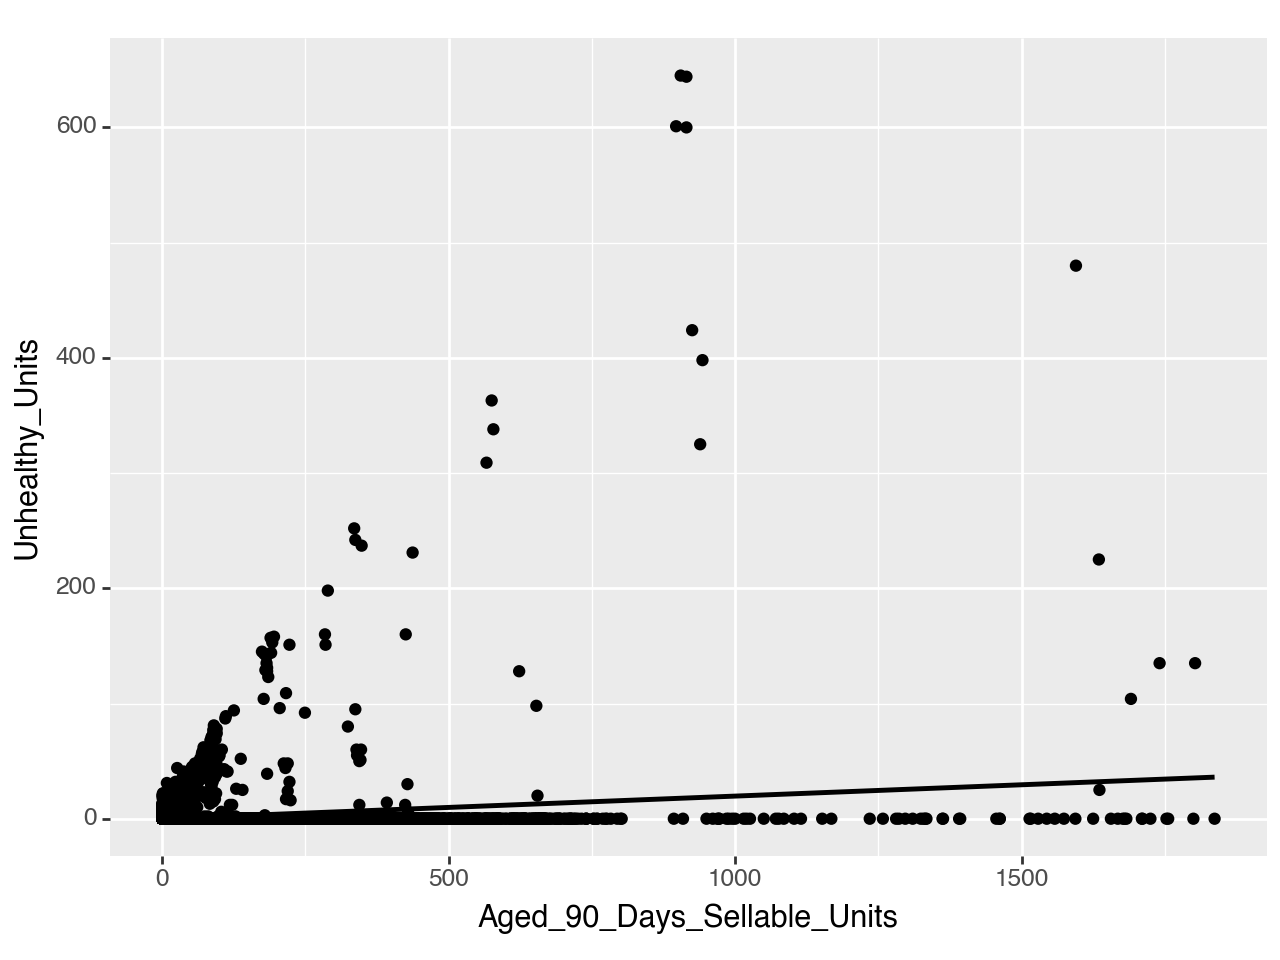

<Figure Size: (640 x 480)>

In [44]:
pn.ggplot(df, pn.aes("Aged_90_Days_Sellable_Units", "Unhealthy_Units")) + \
    pn.geom_point() + \
    pn.geom_smooth(method = "lm", se = False)

In [45]:
df.columns

Index(['ASIN', 'Date', 'Ordered_Units', 'Shipped_Units', 'Net_Received_Units',
       'Open_Purchase_Order_Quantity', 'Aged_90_Days_Sellable_Units',
       'Sellable_On_Hand_Units', 'Unsellable_On_Hand_Units',
       'Unhealthy_Units'],
      dtype='object')

In [46]:
df = df.fillna(0)

In [47]:
y, X = pt.dmatrices("Unhealthy_Units ~ Ordered_Units + Shipped_Units + Net_Received_Units + Open_Purchase_Order_Quantity + Aged_90_Days_Sellable_Units + Sellable_On_Hand_Units + Unsellable_On_Hand_Units", df) # y ~ x
fit = LinearRegression(fit_intercept = False).fit(X, y)


coeffs = fit.coef_[0]
coeffs

df['estimated_unhealthy_units'] = coeffs[0] + coeffs[1] * df['Ordered_Units'] + coeffs[2] * df['Shipped_Units'] \
    + coeffs[3] * df['Net_Received_Units'] + coeffs[4] * df['Open_Purchase_Order_Quantity'] \
    + coeffs[5] * df['Aged_90_Days_Sellable_Units'] + coeffs[6] * df['Sellable_On_Hand_Units'] \
    + coeffs[7] * df['Unsellable_On_Hand_Units']
# split these coefficients out and use df broadcasting to create a new column in the df with the predicted unhealthy units

In [48]:
df.to_csv('project_linear_regression.csv')